**Name:** EDUARDO WILLIAMS

**Student Code:** C0896405

**Date:** 26/Jun/2024

In [212]:
# importing libraries
import pandas  as pd
import numpy   as np
import seaborn as sns
import joblib
from matplotlib import pyplot as plt

from sklearn.svm               import SVC
from sklearn.ensemble          import VotingClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.preprocessing     import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.metrics           import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

**1. Dataset Selection**

The placement of students is one of the most important objective of an educational institution. The model's main goal is to predict whether the student will be recruited in campus placements or not based on the available factors in the dataset.

**Topic:** Campus Recruitment Prediction

**Dataset source:** https://www.kaggle.com/c/ml-with-python-course-project/data

**Dataset name:** train.csv

In [177]:
# loading the dataset
df = pd.read_csv("train.csv")

In [178]:
# verifying dataset's shape
df.shape

(215, 15)

In [179]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    int64  
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(2), object(7)
memory usage: 25.3+ KB


In [180]:
# dataset overview
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [181]:
df["status"].unique()

array(['Placed', 'Not Placed'], dtype=object)

According to previous steps we can conclude the following:

**Dataset rows:** 215

**Dataset columns:** 15

**Dataset categorical columns:** gender, ssc_b, hsc_b, hsc_s, degree_t, workex, specialisation

**Dataset numerical columns:** sl_no, ssc_p, hsc_p, degree_p, etest_p, mba_p, salary

**Target column:** status

**Target categories:** Placed / Not Placed

**2. Data Preprocessing**

In [182]:
# looking for null values
df.isna().sum()

sl_no              0
gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64

In [183]:
# dealing with null values
df.fillna(value={"salary" : 0}, inplace = True)

In [184]:
# removing duplicate rows
df.drop_duplicates(keep = 'first', inplace = True)

According to kaggle **sl_no** column is an anonymous unique id, therefore it is useless for the analysis

In [185]:
# dropping sl_no column
df.drop('sl_no', axis = "columns", inplace = True)

In [186]:
# dropping salary column
df.drop('salary', axis = "columns", inplace = True)

**Encoding**

In [188]:
# verifying unique values for categorical columns
print ("gender",         df["gender"].unique())
print ("ssc_b",          df["ssc_b"].unique())
print ("hsc_b",          df["hsc_b"].unique())
print ("hsc_s",          df["hsc_s"].unique())
print ("degree_t",       df["degree_t"].unique())
print ("workex",         df["workex"].unique())
print ("specialisation", df["specialisation"].unique())

gender [0 1]
ssc_b ['Others' 'Central']
hsc_b ['Others' 'Central']
hsc_s ['Commerce' 'Science' 'Arts']
degree_t ['Sci&Tech' 'Comm&Mgmt' 'Others']
workex ['No' 'Yes']
specialisation ['Mkt&HR' 'Mkt&Fin']


In [189]:
# applying manually encoding to target column (status)
df['status'] = df['status'].map({'Not Placed' : 0, 'Placed' : 1}).astype(int)

Since columns hsc_s and degree_t have more than two values then OneHotEncoding will be applied on them

In [190]:
# applying one hot encoding to hsc_s column
df_hsc_s = pd.get_dummies(df['hsc_s'], dtype = int, prefix = 'hsc_s', prefix_sep = '_')
df = df.join(df_hsc_s)
df.drop('hsc_s', axis = 1, inplace = True)

In [191]:
# applying one hot encoding to degree_t column
df_degree_t = pd.get_dummies(df['degree_t'], dtype = int, prefix = 'degree_t', prefix_sep = '_')
df = df.join(df_degree_t)
df.drop('degree_t', axis = 1, inplace = True)

In [192]:
# splitting data into input and output variable
X = df.drop('status', axis = 1)
y = df['status']

In [193]:
# splitting train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Since columns workex, ssc_b, hsc_b and specialisation have just two different values then LabelEncoder will be applied on them

In [194]:
# applying Label encoding to both train and test datasets
le = LabelEncoder()

X_train['ssc_b'] = le.fit_transform(X_train['ssc_b'])
X_test['ssc_b']  = le.transform(X_test['ssc_b'])

X_train['hsc_b'] = le.fit_transform(X_train['hsc_b'])
X_test['hsc_b']  = le.transform(X_test['hsc_b'])

X_train['workex'] = le.fit_transform(X_train['workex'])
X_test['workex']  = le.transform(X_test['workex'])

X_train['specialisation'] = le.fit_transform(X_train['specialisation'])
X_test['specialisation']  = le.transform(X_test['specialisation'])

**StandardScaler**

In [195]:
# applying fit and transform StandardScaler in train dataset
sc = StandardScaler()
X_train[["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]] = sc.fit_transform(X_train[["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]])


In [196]:
# applying transform StandardScaler in test dataset
X_test[["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]] = sc.transform(X_test[["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]])


In [197]:
# verifying new train dataset shape
X_train.shape

(150, 16)

**Selecting features**

In [198]:
# techniques for selecting features
rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 10)
rfe.fit(X_train, y_train)
rfe.get_feature_names_out()

array(['gender', 'ssc_p', 'hsc_p', 'hsc_b', 'degree_p', 'workex',
       'specialisation', 'mba_p', 'hsc_s_Arts', 'degree_t_Comm&Mgmt'],
      dtype=object)

In [199]:
rfe.ranking_

array([1, 1, 6, 1, 1, 1, 1, 7, 1, 1, 1, 4, 5, 1, 2, 3])

In [200]:
# dropping columns with higher ranking_ values since the have lower importance
X_train.drop(['ssc_b', 'etest_p', 'hsc_s_Commerce', 'hsc_s_Science', 'degree_t_Others', 'degree_t_Sci&Tech'], axis = 1, inplace = True)
X_test.drop(['ssc_b', 'etest_p', 'hsc_s_Commerce', 'hsc_s_Science', 'degree_t_Others', 'degree_t_Sci&Tech'],  axis = 1, inplace = True)


**3. Model Selection**

**Logistic Regression** --> This model was selected since it is highly suitable for binary classification problems.

**Support Vector Machine - SVC** --> Support Vector Machine has two models SVR and SVC, for regression and classification problems accordingly, so for this problem SVC will be used. In addition, this model is suitable for small datasets.

**K-Nearest Neighbors** --> The KNN is chosen because it is one of the simplest model and has good performance when working with small datasets.

**4. Model Training**

**Logistic Regression Model**

In [201]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

lr_r2s          = r2_score(y_test, y_pred_lr)
lr_mae          = mean_absolute_error(y_test, y_pred_lr)
lr_mse          = mean_squared_error(y_test, y_pred_lr)
lr_rmse         = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_accuracy     = accuracy_score(y_test, y_pred_lr)
lr_conf_matrix  = confusion_matrix(y_test, y_pred_lr)
lr_class_report = classification_report(y_test, y_pred_lr)

**Support Vector Machine Model - SVC**

In [202]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

svc_r2s          = r2_score(y_test, y_pred_svc)
svc_mae          = mean_absolute_error(y_test, y_pred_svc)
svc_mse          = mean_squared_error(y_test, y_pred_svc)
svc_rmse         = np.sqrt(mean_squared_error(y_test, y_pred_svc))
svc_accuracy     = accuracy_score(y_test, y_pred_svc)
svc_conf_matrix  = confusion_matrix(y_test, y_pred_svc)
svc_class_report = classification_report(y_test, y_pred_svc)

**K-Nearest Neighbors**

In [203]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

knn_r2s          = r2_score(y_test, y_pred_knn)
knn_mae          = mean_absolute_error(y_test, y_pred_knn)
knn_mse          = mean_squared_error(y_test, y_pred_knn)
knn_rmse         = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_accuracy     = accuracy_score(y_test, y_pred_knn)
knn_conf_matrix  = confusion_matrix(y_test, y_pred_knn)
knn_class_report = classification_report(y_test, y_pred_knn)

**5. Model Evaluation**


***********************************
**  LOGISTIC REGRESSION RESULTS  **
***********************************

Accuracy: 0.8
R2 score: 0.0854978354978354
MAE: 0.2
MSE: 0.2
RMSE: 0.4472135954999579
Confussion Matrix
[[12  9]
 [ 4 40]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.57      0.65        21
           1       0.82      0.91      0.86        44

    accuracy                           0.80        65
   macro avg       0.78      0.74      0.75        65
weighted avg       0.79      0.80      0.79        65



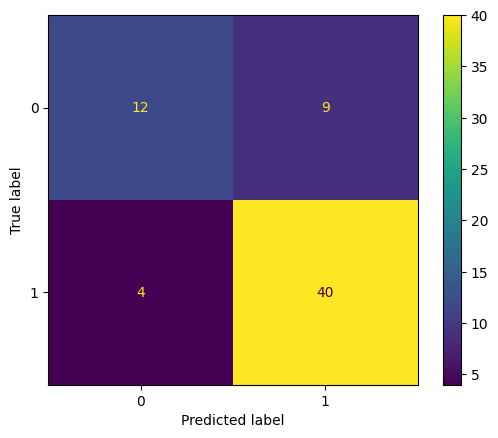

In [204]:
print ('''
***********************************
**  LOGISTIC REGRESSION RESULTS  **
***********************************
''')
print ('Accuracy:', lr_accuracy)
print ('R2 score:', lr_r2s)
print ('MAE:',      lr_mae)
print ('MSE:',      lr_mse)
print ('RMSE:',     lr_rmse)
print('Confussion Matrix')
print(lr_conf_matrix)
print('Classification Report')
print(lr_class_report)

cmd = ConfusionMatrixDisplay(confusion_matrix = lr_conf_matrix, display_labels = lr.classes_)
cmd.plot()


**************************************
**  SUPPORT VECTOR MACHINE RESULTS  **
**************************************

Accuracy: 0.7692307692307693
R2 score: -0.05519480519480524
MAE: 0.23076923076923078
MSE: 0.23076923076923078
RMSE: 0.4803844614152614
Confussion Matrix
[[ 9 12]
 [ 3 41]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.77      0.93      0.85        44

    accuracy                           0.77        65
   macro avg       0.76      0.68      0.70        65
weighted avg       0.77      0.77      0.75        65



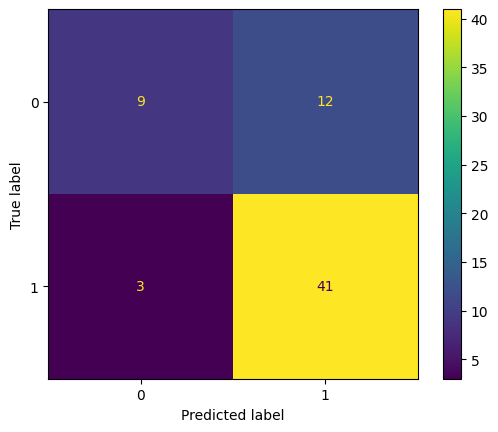

In [205]:
print ('''
**************************************
**  SUPPORT VECTOR MACHINE RESULTS  **
**************************************
''')
print ('Accuracy:', svc_accuracy)
print ('R2 score:', svc_r2s)
print ('MAE:',      svc_mae)
print ('MSE:',      svc_mse)
print ('RMSE:',     svc_rmse)
print('Confussion Matrix')
print(svc_conf_matrix)
print('Classification Report')
print(svc_class_report)

cmd = ConfusionMatrixDisplay(confusion_matrix = svc_conf_matrix, display_labels = svc.classes_)
cmd.plot()


***************************
**  K-NEAREST NEIGHBORS  **
***************************

Accuracy: 0.8
R2 score: 0.0854978354978354
MAE: 0.2
MSE: 0.2
RMSE: 0.4472135954999579
Confussion Matrix
[[10 11]
 [ 2 42]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        21
           1       0.79      0.95      0.87        44

    accuracy                           0.80        65
   macro avg       0.81      0.72      0.74        65
weighted avg       0.81      0.80      0.78        65



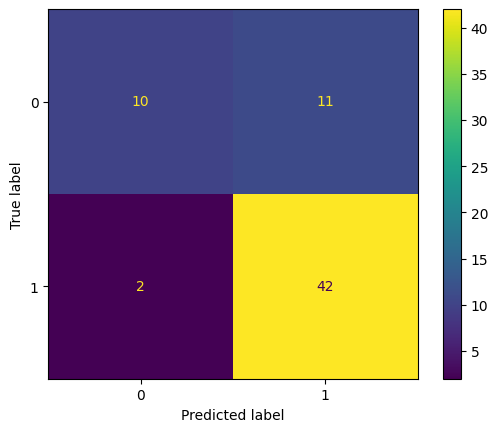

In [207]:
print ('''
***************************
**  K-NEAREST NEIGHBORS  **
***************************
''')
print ('Accuracy:', knn_accuracy)
print ('R2 score:', knn_r2s)
print ('MAE:',      knn_mae)
print ('MSE:',      knn_mse)
print ('RMSE:',     knn_rmse)
print('Confussion Matrix')
print(knn_conf_matrix)
print('Classification Report')
print(knn_class_report)

cmd = ConfusionMatrixDisplay(confusion_matrix = knn_conf_matrix, display_labels = knn.classes_)
cmd.plot()

**Grid Search Cross-Validation**

In [208]:
# defining model names
models = {'Logistic Regression'    : LogisticRegression(),
          'Support Vector Machine' : SVC(),
          'K-Nearest Neighbors'    : KNeighborsClassifier()}

# defining params grid
param_grids = {'Logistic Regression'    : {'solver'     : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                           'penalty'    : ['l1', 'l2', 'elasticnet', None],
                                           'C'          : [0.001, 0.01, 0.1, 1, 10, 100]},
               'Support Vector Machine' : {'C'          : [0.001, 0.01, 0.1, 1, 10, 100],
                                           'gamma'      : [1, 0.1, 0.01, 0.001, 0.0001],
                                           'kernel'     : ['rbf']},
               'K-Nearest Neighbors'    : {'n_neighbors': np.arange(2, 30, 1)}}

best_estimators = {}
best_scores = {}

for name, model in models.items():
    grid = GridSearchCV(estimator = model, param_grid = param_grids[name], cv = 5, scoring = 'neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    best_estimators[name] = grid.best_estimator_
    best_scores[name]     = mean_squared_error(y_test, grid.best_estimator_.predict(X_test))
    
    print(f'Performing grid search for {name}...')
    print(f'Best params: {grid.best_params_}')
    print(f'Best scores: {grid.best_score_}')
    print(f'Test MSE:    {best_scores[name]}\n')
    
# identifying the best model (which has the lowest MSE)
best_mse = 999999999
best_est = ""

for name, model in models.items():
    if best_scores[name] < best_mse:
       best_mse = best_scores[name]
       best_est = best_estimators[name]

print (f"The best model is {best_est}")

Performing grid search for Logistic Regression...
Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best scores: -0.11333333333333333
Test MSE:    0.18461538461538463

Performing grid search for Support Vector Machine...
Best params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best scores: -0.13333333333333333
Test MSE:    0.2153846153846154

Performing grid search for K-Nearest Neighbors...
Best params: {'n_neighbors': 15}
Best scores: -0.12
Test MSE:    0.23076923076923078

The best model is LogisticRegression(C=1, solver='liblinear')



***********************************
**  LOGISTIC REGRESSION RESULTS  **
***********************************

Accuracy: 0.8153846153846154
R2 score: 0.15584415584415579
MAE: 0.18461538461538463
MSE: 0.18461538461538463
RMSE: 0.4296689244236597
Confussion Matrix
[[13  8]
 [ 4 40]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.83      0.91      0.87        44

    accuracy                           0.82        65
   macro avg       0.80      0.76      0.78        65
weighted avg       0.81      0.82      0.81        65



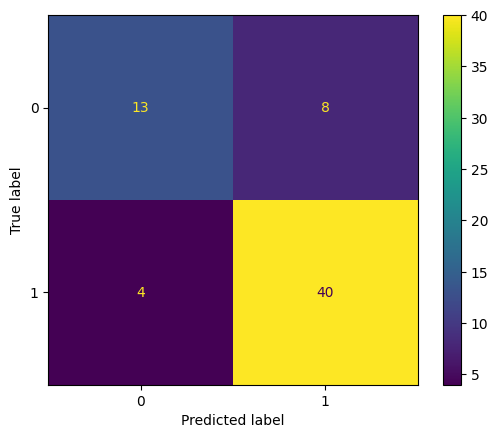

In [209]:
# Logistic Regression with recommended hyper-parameters
lr = LogisticRegression(C = 1, solver = 'liblinear')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

lr_r2s          = r2_score(y_test, y_pred_lr)
lr_mae          = mean_absolute_error(y_test, y_pred_lr)
lr_mse          = mean_squared_error(y_test, y_pred_lr)
lr_rmse         = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_accuracy     = accuracy_score(y_test, y_pred_lr)
lr_conf_matrix  = confusion_matrix(y_test, y_pred_lr)
lr_class_report = classification_report(y_test, y_pred_lr)

print ('''
***********************************
**  LOGISTIC REGRESSION RESULTS  **
***********************************
''')
print ('Accuracy:', lr_accuracy)
print ('R2 score:', lr_r2s)
print ('MAE:',      lr_mae)
print ('MSE:',      lr_mse)
print ('RMSE:',     lr_rmse)
print('Confussion Matrix')
print(lr_conf_matrix)
print('Classification Report')
print(lr_class_report)

cmd = ConfusionMatrixDisplay(confusion_matrix = lr_conf_matrix, display_labels = lr.classes_)
cmd.plot()

**6. Voting Classifier**


***************************
**  K-NEAREST NEIGHBORS  **
***************************

Accuracy: 0.7846153846153846
R2 score: 0.015151515151515138
MAE: 0.2153846153846154
MSE: 0.2153846153846154
RMSE: 0.4640954808922571
Confussion Matrix
[[10 11]
 [ 3 41]]
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.79      0.93      0.85        44

    accuracy                           0.78        65
   macro avg       0.78      0.70      0.72        65
weighted avg       0.78      0.78      0.77        65



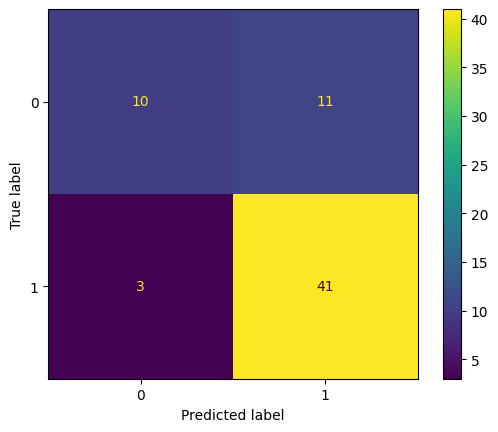

In [210]:
vc = VotingClassifier(estimators=[('LogisticRegression', lr ),
                                  ('SVM',                svc),
                                  ('KNN',                knn)], voting='hard')
vc.fit(X_train, y_train)

y_pred_vc = vc.predict(X_test)

vc_r2s          = r2_score(y_test, y_pred_vc)
vc_mae          = mean_absolute_error(y_test, y_pred_vc)
vc_mse          = mean_squared_error(y_test, y_pred_vc)
vc_rmse         = np.sqrt(mean_squared_error(y_test, y_pred_vc))
vc_accuracy     = accuracy_score(y_test, y_pred_vc)
vc_conf_matrix  = confusion_matrix(y_test, y_pred_vc)
vc_class_report = classification_report(y_test, y_pred_vc)

print ('''
***************************
**  K-NEAREST NEIGHBORS  **
***************************
''')
print ('Accuracy:', vc_accuracy)
print ('R2 score:', vc_r2s)
print ('MAE:',      vc_mae)
print ('MSE:',      vc_mse)
print ('RMSE:',     vc_rmse)
print('Confussion Matrix')
print(vc_conf_matrix)
print('Classification Report')
print(vc_class_report)

cmd = ConfusionMatrixDisplay(confusion_matrix = vc_conf_matrix, display_labels = vc.classes_)
cmd.plot()

**Generating the best model**

In [213]:
# saving the best model
joblib.dump(lr, "model.pkl")

['model.pkl']